<a name="final-project"></a>
## Final Project

<p class="lead">
<a href="https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info">Creative Applications of Deep Learning with Google's Tensorflow</a><br />
<a href="http://pkmital.com">Parag K. Mital</a><br />
<a href="https://www.kadenze.com">Kadenze, Inc.</a>
</p>

In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher as the libraries built for this course',
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda'
          'and then restart `jupyter notebook`:\n',
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import librosa
    import librosa.display
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    from scipy.ndimage.filters import gaussian_filter
    import IPython.display as ipyd
    import tensorflow as tf
    from libs import utils, gif, datasets, dataset_utils, vae, dft, vgg16, nb_utils
except ImportError:
    print("Make sure you have started notebook in the same directory",
          "as the provided zip file which includes the 'libs' folder",
          "and the file 'utils.py' inside of it.  You will NOT be able",
          "to complete this assignment unless you restart jupyter",
          "notebook inside the directory created by extracting",
          "the zip file or cloning the github repo.  If you are still")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

import imageio
from skimage import img_as_ubyte

In [2]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="audio-style-transfer"></a>
## Part 1: Audio Style Transfer

Reference: https://dmitryulyanov.github.io/audio-texture-synthesis-and-style-transfer/

In [3]:
CONTENT_FILENAME  = "imperial.mp3"
STYLE_FILENAME  = "eminem.mp3"

In [4]:
N_FFT = 2048
fs = 16000
def read_audio_spectum(filename):
    x, sr = librosa.load(filename, duration=10, mono=True)
    x = librosa.resample(x, sr, fs)
    S = librosa.stft(x)    
    S = np.log1p(np.abs(S)) 
    return S, fs

In [5]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

print(a_content.shape)
print(a_style.shape)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]

(1025, 313)
(1025, 313)


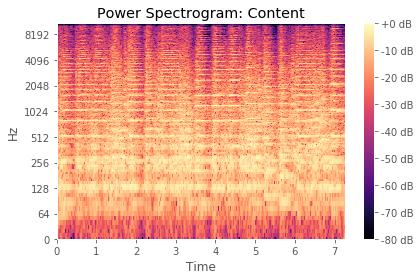

In [6]:
librosa.display.specshow(librosa.amplitude_to_db(a_content, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power Spectrogram: Content')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

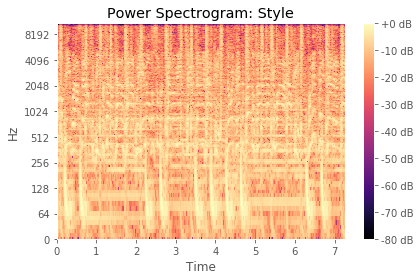

In [7]:
librosa.display.specshow(librosa.amplitude_to_db(a_style, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power Spectrogram: Style')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [8]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.tanh(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

In [9]:
from sys import stderr

learning_rate= 1e-3
iterations = 300

result = None
with tf.Graph().as_default():

    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.tanh(conv)

    content_loss = tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = tf.nn.l2_loss(gram - style_gram)

    loss = 0.01 * content_loss + 0.99 * style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print ('Final loss:', loss.eval())
        result = x.eval()

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1316.572144
  Number of iterations: 300
  Number of functions evaluations: 315
Final loss: 1316.5721


In [10]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
S = a * np.exp(1j*p)
x = librosa.istft(S)

OUTPUT_FILENAME = 'out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

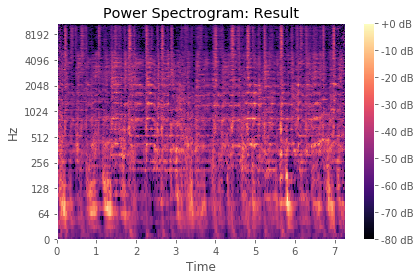

In [11]:
librosa.display.specshow(librosa.amplitude_to_db(a, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power Spectrogram: Result')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

<a name="image-style-transfer"></a>
## Part 2: Image Style Transfer using VGG Face Model

Reference: Session 4 (Visualizing Representations)

In [12]:
from libs import vgg16

sess.close()
tf.reset_default_graph()

net = vgg16.get_vgg_face_model()

device = '/cpu:0'

g = tf.Graph()

with tf.Session(graph=g) as sess, g.device(device):
    tf.import_graph_def(net['graph_def'], name='net')
    
names = [op.name for op in g.get_operations()]

In [13]:
print(names)

['net/Placeholder', 'net/conv1_1/weights', 'net/conv1_1/weights/read', 'net/conv1_1/biases', 'net/conv1_1/biases/read', 'net/conv1_1/Conv2D', 'net/conv1_1/BiasAdd', 'net/conv1_1/conv1_1', 'net/conv1_2/weights', 'net/conv1_2/weights/read', 'net/conv1_2/biases', 'net/conv1_2/biases/read', 'net/conv1_2/Conv2D', 'net/conv1_2/BiasAdd', 'net/conv1_2/conv1_2', 'net/pool1', 'net/conv2_1/weights', 'net/conv2_1/weights/read', 'net/conv2_1/biases', 'net/conv2_1/biases/read', 'net/conv2_1/Conv2D', 'net/conv2_1/BiasAdd', 'net/conv2_1/conv2_1', 'net/conv2_2/weights', 'net/conv2_2/weights/read', 'net/conv2_2/biases', 'net/conv2_2/biases/read', 'net/conv2_2/Conv2D', 'net/conv2_2/BiasAdd', 'net/conv2_2/conv2_2', 'net/pool2', 'net/conv3_1/weights', 'net/conv3_1/weights/read', 'net/conv3_1/biases', 'net/conv3_1/biases/read', 'net/conv3_1/Conv2D', 'net/conv3_1/BiasAdd', 'net/conv3_1/conv3_1', 'net/conv3_2/weights', 'net/conv3_2/weights/read', 'net/conv3_2/biases', 'net/conv3_2/biases/read', 'net/conv3_2/C

C:\Users\vtan25\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\vtan25\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\vtan25\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


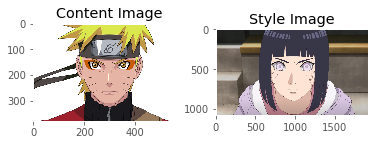

In [14]:
content_og = plt.imread('naruto.jpg')[..., :3]
style_og = plt.imread('hinata.png')[..., :3]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_og)
axs[0].set_title('Content Image')
axs[0].grid('off')
axs[1].imshow(style_og)
axs[1].set_title('Style Image')
axs[1].grid('off')

plt.imsave(arr=content_og, fname='content.png')
plt.imsave(arr=style_og, fname='style.png')

content_img = net['preprocess'](content_og)[np.newaxis]
style_img = net['preprocess'](style_og)[np.newaxis]

In [15]:
x = g.get_tensor_by_name(names[0] + ":0")

softmax = g.get_tensor_by_name(names[-2] + ':0')

keep_probability = np.ones([1, 4096])

for img in [content_img, style_img]:
    with tf.Session(graph=g) as sess, g.device('/cpu:0'):
        res = softmax.eval(feed_dict={x: img})[0]
        print([(res[idx], net['labels'][idx])
               for idx in res.argsort()[-5:][::-1]])

[(5.005411, 'Hans_Zimmer'), (4.0613627, 'Jenna_Ushkowitz'), (3.9967113, 'Mariel_Hemingway'), (3.735013, 'Drew_Roy'), (3.6559358, 'Shad_Moss')]
[(5.005874, 'Hans_Zimmer'), (4.0618305, 'Jenna_Ushkowitz'), (3.9979815, 'Mariel_Hemingway'), (3.733963, 'Drew_Roy'), (3.6543999, 'Shad_Moss')]


In [16]:
content_layer = 'net/conv5_2/conv5_2:0'

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_features = g.get_tensor_by_name(content_layer).eval(
            session=sess,
            feed_dict={x: content_img})

In [17]:
style_layers = ['net/conv1_1/conv1_1:0',
                'net/conv2_1/conv2_1:0',
                'net/conv3_1/conv3_1:0',
                'net/conv4_1/conv4_1:0',
                'net/conv5_1/conv5_1:0']
style_activations = []

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    for style_i in style_layers:
        style_activation_i = g.get_tensor_by_name(style_i).eval(
            feed_dict={x: style_img})
        style_activations.append(style_activation_i)
        
style_features = []
for style_activation_i in style_activations:
    s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]])
    gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
    style_features.append(gram_matrix.astype(np.float32))

In [18]:
tf.reset_default_graph()
g = tf.Graph()

net = vgg16.get_vgg_face_model()

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    net_input = tf.Variable(content_img)

    tf.import_graph_def(
        net['graph_def'],
        name='net',
        input_map={'Placeholder:0': net_input})

In [19]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_loss = tf.nn.l2_loss((g.get_tensor_by_name(content_layer) -
                                 content_features) /
                                 content_features.size)

In [20]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    style_loss = np.float32(0.0)
    for style_layer_i, style_gram_i in zip(style_layers, style_features):
        layer_i = g.get_tensor_by_name(style_layer_i)
        layer_shape = layer_i.get_shape().as_list()
        layer_size = layer_shape[1] * layer_shape[2] * layer_shape[3]
        layer_flat = tf.reshape(layer_i, [-1, layer_shape[3]])
        gram_matrix = tf.matmul(tf.transpose(layer_flat), layer_flat) / layer_size
        style_loss = tf.add(style_loss, tf.nn.l2_loss((gram_matrix - style_gram_i) / np.float32(style_gram_i.size)))

In [21]:
def total_variation_loss(x):
    h, w = x.get_shape().as_list()[1], x.get_shape().as_list()[1]
    dx = tf.square(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
    dy = tf.square(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
    return tf.reduce_sum(tf.pow(dx + dy, 1.25))

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tv_loss = total_variation_loss(net_input)

In [22]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    loss = 0.1 * content_loss + 0.9 * style_loss + 0.01 * tv_loss
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

0: 23.114267, (-0.002845 - 1.008372)


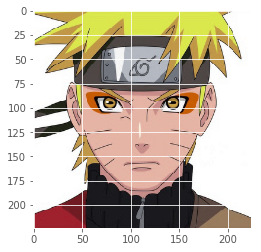

1: 20.788364, (0.001165 - 1.014698)
2: 18.679865, (0.002336 - 1.008977)
3: 16.788891, (0.002182 - 1.007277)
4: 15.086329, (0.005299 - 1.006780)
5: 13.549625, (0.007537 - 1.007346)


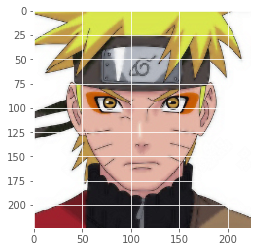

6: 12.165159, (0.008097 - 1.006799)
7: 10.920420, (0.009267 - 1.006701)
8: 9.802334, (0.012232 - 1.006185)
9: 8.798527, (0.009202 - 1.006558)
10: 7.897898, (0.008180 - 1.006198)


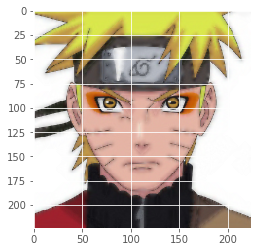

11: 7.090738, (0.010079 - 1.004674)
12: 6.368206, (0.013729 - 1.004962)
13: 5.721864, (0.016848 - 1.005580)
14: 5.143893, (0.020009 - 1.005437)
15: 4.627124, (0.022971 - 1.004298)


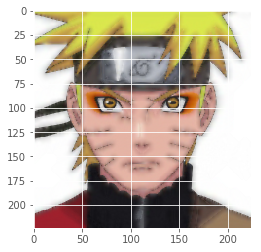

16: 4.165162, (0.022657 - 1.004233)
17: 3.752266, (0.020916 - 1.003024)
18: 3.383228, (0.020148 - 1.006382)
19: 3.053327, (0.020529 - 1.007218)
20: 2.758320, (0.022164 - 1.005081)


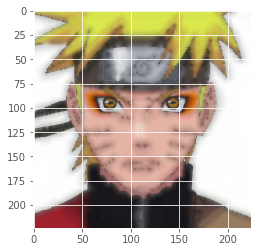

21: 2.494432, (0.025059 - 1.002355)
22: 2.258270, (0.029138 - 1.002577)
23: 2.046800, (0.034272 - 1.002373)
24: 1.857324, (0.036871 - 1.002332)
25: 1.687435, (0.040596 - 1.002452)


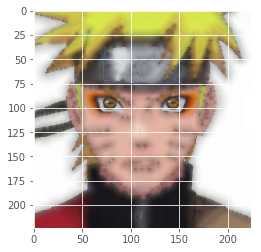

26: 1.534992, (0.045398 - 1.002851)
27: 1.398088, (0.047455 - 1.003303)
28: 1.275022, (0.048982 - 1.003570)
29: 1.164274, (0.051144 - 1.003739)
30: 1.064501, (0.053950 - 1.003862)


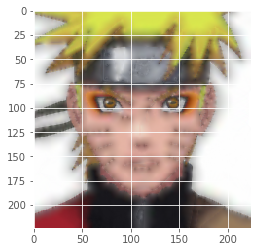

31: 0.974515, (0.055667 - 1.004003)
32: 0.893271, (0.056916 - 1.004085)
33: 0.819839, (0.058659 - 1.004121)
34: 0.753404, (0.060843 - 1.004190)
35: 0.693238, (0.062767 - 1.004254)


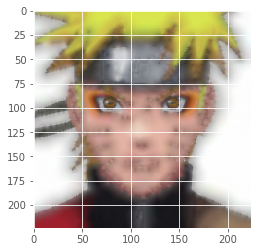

36: 0.638701, (0.064655 - 1.004313)
37: 0.589221, (0.066874 - 1.004153)
38: 0.544293, (0.069291 - 1.004027)
39: 0.503465, (0.071409 - 1.003814)
40: 0.466328, (0.072280 - 1.003174)


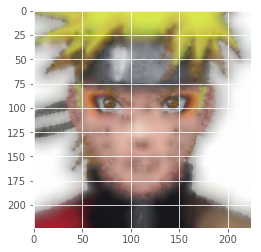

41: 0.432527, (0.072980 - 1.004523)
42: 0.401737, (0.072726 - 1.005316)
43: 0.373669, (0.071519 - 1.004100)
44: 0.348064, (0.070437 - 1.004349)
45: 0.324689, (0.069729 - 1.005326)


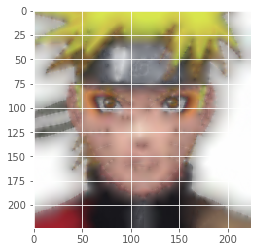

46: 0.303335, (0.069518 - 1.005146)
47: 0.283816, (0.069888 - 1.003935)
48: 0.265962, (0.070852 - 1.003205)
49: 0.249620, (0.072334 - 1.002641)
50: 0.234649, (0.074188 - 1.001531)


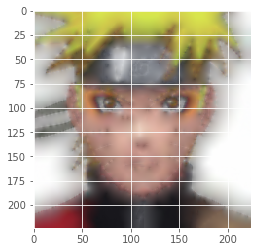

51: 0.220923, (0.076085 - 1.001519)
52: 0.208326, (0.075613 - 1.002503)
53: 0.196756, (0.075134 - 1.002091)
54: 0.186114, (0.074822 - 1.001934)
55: 0.176317, (0.074679 - 1.001457)


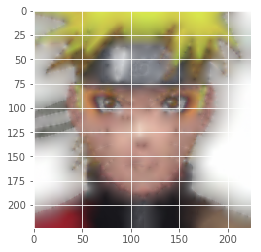

56: 0.167289, (0.074699 - 1.000154)
57: 0.158958, (0.074865 - 1.000170)
58: 0.151260, (0.075154 - 1.000303)
59: 0.144140, (0.075538 - 1.000251)
60: 0.137547, (0.075988 - 1.000460)


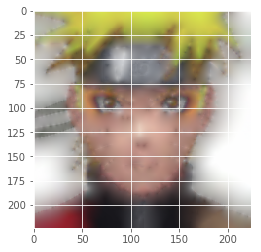

61: 0.131433, (0.076477 - 1.000470)
62: 0.125756, (0.076960 - 1.000273)
63: 0.120478, (0.077445 - 0.999650)
64: 0.115565, (0.077972 - 0.998732)
65: 0.110988, (0.078277 - 0.998555)


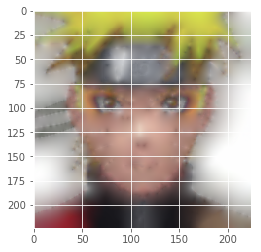

66: 0.106715, (0.078347 - 0.998577)
67: 0.102724, (0.078446 - 0.998553)
68: 0.098989, (0.078572 - 0.998547)
69: 0.095489, (0.078721 - 0.998470)
70: 0.092207, (0.078887 - 0.998409)


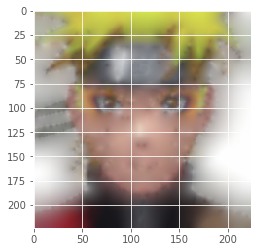

71: 0.089124, (0.079066 - 0.998475)
72: 0.086224, (0.079251 - 0.998512)
73: 0.083492, (0.079438 - 0.998466)
74: 0.080916, (0.079450 - 0.998343)
75: 0.078482, (0.079336 - 0.998175)


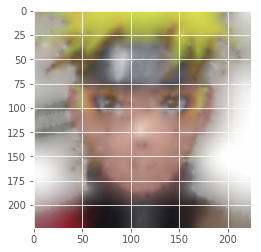

76: 0.076180, (0.079178 - 0.998106)
77: 0.074001, (0.079063 - 0.998106)
78: 0.071935, (0.078989 - 0.998067)
79: 0.069975, (0.078956 - 0.998143)
80: 0.068112, (0.078960 - 0.998219)


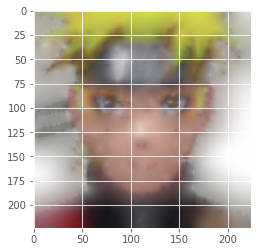

81: 0.066340, (0.078996 - 0.998224)
82: 0.064652, (0.079060 - 0.998166)
83: 0.063044, (0.079147 - 0.998070)
84: 0.061509, (0.079251 - 0.998033)
85: 0.060041, (0.079367 - 0.998026)


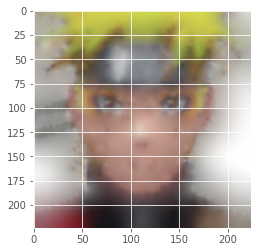

86: 0.058638, (0.079491 - 0.998016)
87: 0.057296, (0.079619 - 0.998014)
88: 0.056011, (0.079749 - 0.998007)
89: 0.054778, (0.079878 - 0.997998)
90: 0.053594, (0.080004 - 0.997997)


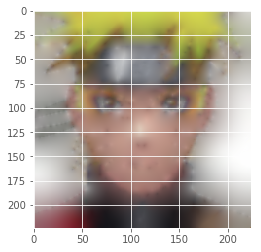

91: 0.052458, (0.080125 - 0.997998)
92: 0.051365, (0.080242 - 0.998006)
93: 0.050313, (0.080352 - 0.998017)
94: 0.049302, (0.080457 - 0.998013)
95: 0.048328, (0.080555 - 0.997994)


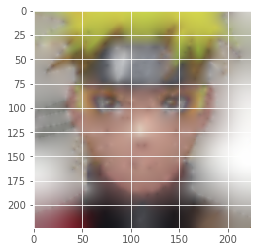

96: 0.047388, (0.080648 - 0.997962)
97: 0.046481, (0.080734 - 0.997929)
98: 0.045606, (0.080725 - 0.997945)
99: 0.044760, (0.080705 - 0.997963)
100: 0.043942, (0.080693 - 0.997912)


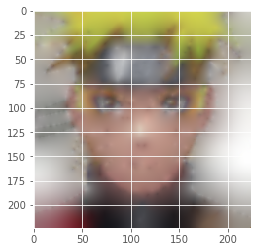

101: 0.043150, (0.080689 - 0.997891)
102: 0.042383, (0.080693 - 0.997878)
103: 0.041641, (0.080703 - 0.997854)
104: 0.040921, (0.080720 - 0.997846)
105: 0.040224, (0.080742 - 0.997824)


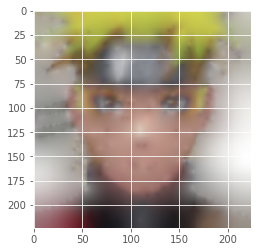

106: 0.039547, (0.080768 - 0.997784)
107: 0.038890, (0.080799 - 0.997733)
108: 0.038253, (0.080833 - 0.997707)
109: 0.037633, (0.080870 - 0.997575)
110: 0.037031, (0.080910 - 0.997441)


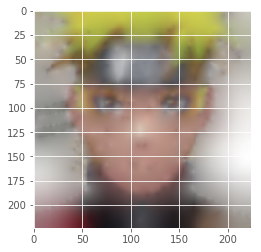

111: 0.036445, (0.080952 - 0.997227)
112: 0.035876, (0.080994 - 0.996729)
113: 0.035321, (0.081038 - 0.996103)
114: 0.034780, (0.081082 - 0.995253)
115: 0.034254, (0.081127 - 0.994623)


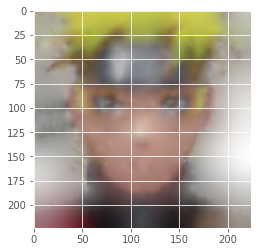

116: 0.033742, (0.081171 - 0.993365)
117: 0.033242, (0.081200 - 0.992601)
118: 0.032755, (0.081209 - 0.992120)
119: 0.032280, (0.081221 - 0.991155)
120: 0.031816, (0.081235 - 0.989986)


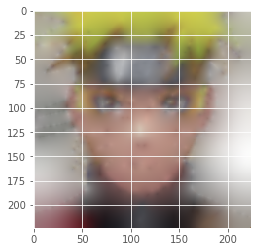

121: 0.031364, (0.081252 - 0.988789)
122: 0.030922, (0.081271 - 0.988370)
123: 0.030491, (0.081293 - 0.986995)
124: 0.030070, (0.081316 - 0.985304)
125: 0.029658, (0.081339 - 0.984024)


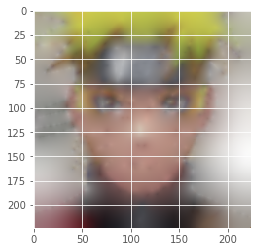

126: 0.029255, (0.081355 - 0.982163)
127: 0.028862, (0.081373 - 0.981034)
128: 0.028477, (0.081394 - 0.980056)
129: 0.028101, (0.081419 - 0.978619)
130: 0.027734, (0.081446 - 0.977026)


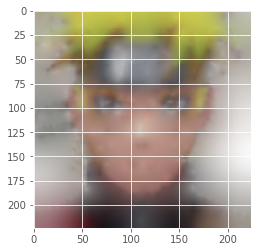

131: 0.027373, (0.081478 - 0.976233)
132: 0.027021, (0.081493 - 0.975123)
133: 0.026676, (0.081495 - 0.973873)
134: 0.026338, (0.081499 - 0.972123)
135: 0.026007, (0.081507 - 0.970186)


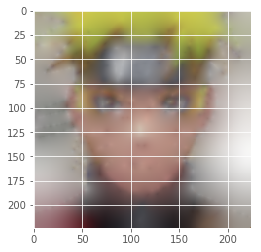

136: 0.025682, (0.081517 - 0.968769)
137: 0.025364, (0.081530 - 0.967668)
138: 0.025053, (0.081547 - 0.966211)
139: 0.024748, (0.081567 - 0.964662)
140: 0.024449, (0.081591 - 0.963454)


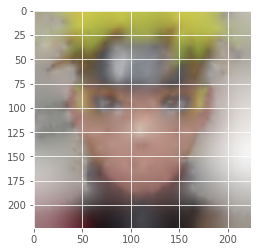

141: 0.024155, (0.081620 - 0.961848)
142: 0.023868, (0.081654 - 0.959985)
143: 0.023586, (0.081695 - 0.958070)
144: 0.023309, (0.081743 - 0.956260)
145: 0.023038, (0.081801 - 0.954656)


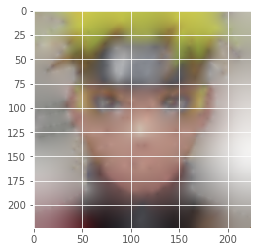

146: 0.022772, (0.081871 - 0.953068)
147: 0.022510, (0.081955 - 0.951567)
148: 0.022253, (0.082057 - 0.950033)
149: 0.022001, (0.082180 - 0.948380)
150: 0.021754, (0.082327 - 0.946818)


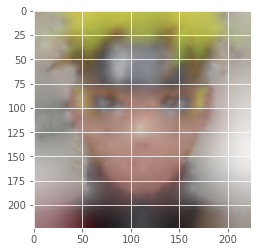

151: 0.021511, (0.082504 - 0.945298)
152: 0.021272, (0.082712 - 0.943865)
153: 0.021037, (0.082955 - 0.942415)
154: 0.020807, (0.083235 - 0.940869)
155: 0.020580, (0.083553 - 0.939382)


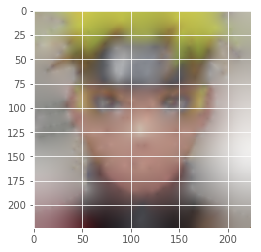

156: 0.020358, (0.083910 - 0.937884)
157: 0.020139, (0.084304 - 0.936342)
158: 0.019924, (0.084733 - 0.934744)
159: 0.019713, (0.085144 - 0.933100)
160: 0.019506, (0.085579 - 0.931486)


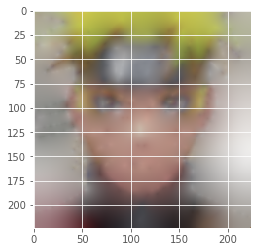

161: 0.019301, (0.086042 - 0.929994)
162: 0.019101, (0.086532 - 0.928486)
163: 0.018903, (0.087047 - 0.926954)
164: 0.018709, (0.087585 - 0.925389)
165: 0.018517, (0.088144 - 0.923795)


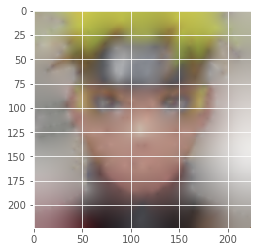

166: 0.018329, (0.088722 - 0.922186)
167: 0.018144, (0.089317 - 0.920585)
168: 0.017962, (0.089928 - 0.919012)
169: 0.017782, (0.090552 - 0.917476)
170: 0.017606, (0.091188 - 0.915976)


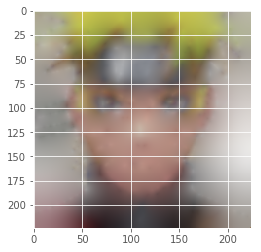

171: 0.017432, (0.091836 - 0.914502)
172: 0.017261, (0.092493 - 0.913041)
173: 0.017093, (0.093160 - 0.911585)
174: 0.016927, (0.093835 - 0.910127)
175: 0.016764, (0.094511 - 0.908666)


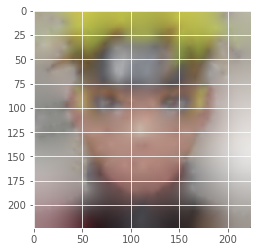

176: 0.016604, (0.095204 - 0.907202)
177: 0.016445, (0.095910 - 0.905736)
178: 0.016289, (0.096618 - 0.904267)
179: 0.016135, (0.097335 - 0.902801)
180: 0.015983, (0.098061 - 0.901411)


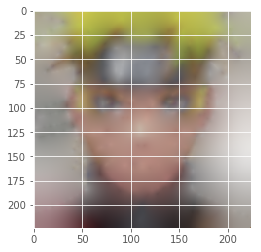

181: 0.015833, (0.098797 - 0.900009)
182: 0.015685, (0.099543 - 0.898600)
183: 0.015540, (0.100299 - 0.897196)
184: 0.015397, (0.101067 - 0.895803)
185: 0.015256, (0.101846 - 0.894422)


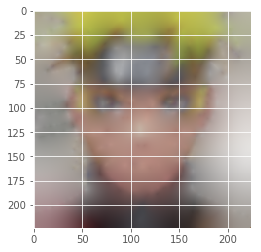

186: 0.015116, (0.102636 - 0.893048)
187: 0.014979, (0.103439 - 0.891675)
188: 0.014844, (0.104253 - 0.890298)
189: 0.014711, (0.105080 - 0.888919)
190: 0.014579, (0.105917 - 0.887538)


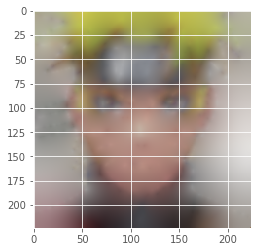

191: 0.014450, (0.106766 - 0.886159)
192: 0.014322, (0.107625 - 0.884782)
193: 0.014196, (0.108493 - 0.883415)
194: 0.014072, (0.109371 - 0.882071)
195: 0.013950, (0.110258 - 0.880726)


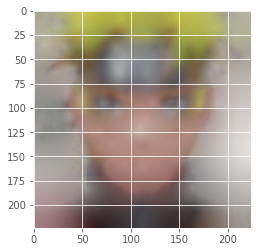

196: 0.013830, (0.111152 - 0.879381)
197: 0.013712, (0.112052 - 0.878042)
198: 0.013596, (0.112959 - 0.876774)
199: 0.013480, (0.113871 - 0.875503)
200: 0.013366, (0.114787 - 0.874227)


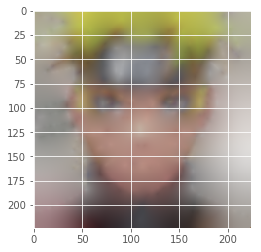

201: 0.013252, (0.115708 - 0.872951)
202: 0.013141, (0.116631 - 0.871682)
203: 0.013032, (0.117558 - 0.870423)
204: 0.012924, (0.118487 - 0.869173)
205: 0.012818, (0.119418 - 0.867930)


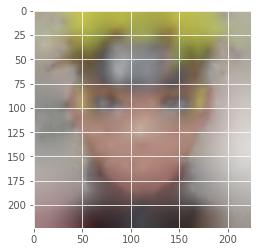

206: 0.012713, (0.120350 - 0.866694)
207: 0.012609, (0.121285 - 0.865465)
208: 0.012506, (0.122220 - 0.864242)
209: 0.012404, (0.123157 - 0.863023)
210: 0.012303, (0.124096 - 0.861805)


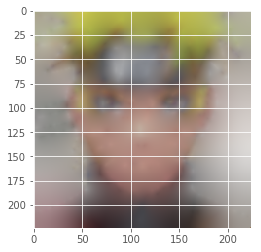

211: 0.012204, (0.125036 - 0.860590)
212: 0.012105, (0.125977 - 0.859380)
213: 0.012009, (0.126919 - 0.858174)
214: 0.011913, (0.127863 - 0.856974)
215: 0.011819, (0.128809 - 0.855778)


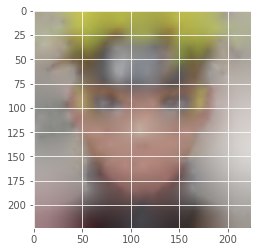

216: 0.011725, (0.129756 - 0.854587)
217: 0.011634, (0.130705 - 0.853403)
218: 0.011542, (0.131656 - 0.852245)
219: 0.011452, (0.132608 - 0.851100)
220: 0.011364, (0.133561 - 0.849960)


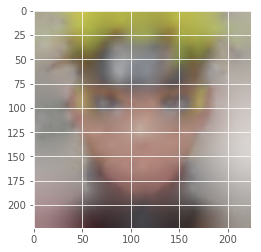

221: 0.011276, (0.134516 - 0.848825)
222: 0.011190, (0.135472 - 0.847695)
223: 0.011104, (0.136430 - 0.846568)
224: 0.011020, (0.137389 - 0.845444)
225: 0.010937, (0.138348 - 0.844324)


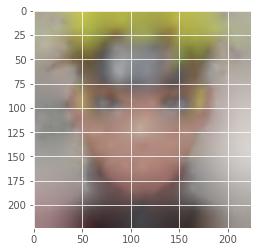

226: 0.010854, (0.139309 - 0.843221)
227: 0.010773, (0.140270 - 0.842128)
228: 0.010692, (0.141232 - 0.841048)
229: 0.010612, (0.142194 - 0.839979)
230: 0.010533, (0.143157 - 0.838915)


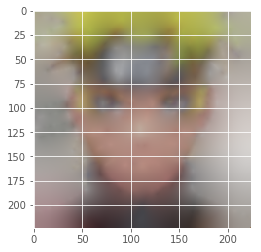

231: 0.010456, (0.144120 - 0.837851)
232: 0.010379, (0.145083 - 0.836785)
233: 0.010303, (0.146046 - 0.835720)
234: 0.010228, (0.147010 - 0.834676)
235: 0.010154, (0.147973 - 0.833659)


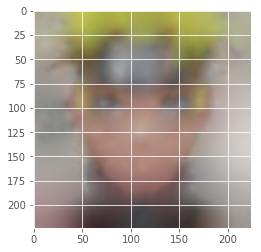

236: 0.010080, (0.148936 - 0.832654)
237: 0.010008, (0.149899 - 0.831652)
238: 0.009936, (0.150863 - 0.830646)
239: 0.009866, (0.151826 - 0.829633)
240: 0.009796, (0.152788 - 0.828619)


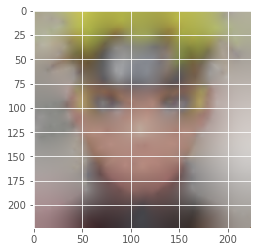

241: 0.009727, (0.153751 - 0.827609)
242: 0.009658, (0.154713 - 0.826633)
243: 0.009590, (0.155675 - 0.825674)
244: 0.009523, (0.156636 - 0.824698)
245: 0.009456, (0.157596 - 0.823713)


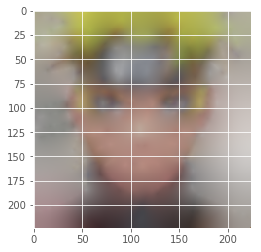

246: 0.009391, (0.158557 - 0.822731)
247: 0.009326, (0.159516 - 0.821763)
248: 0.009262, (0.160474 - 0.820813)
249: 0.009199, (0.161432 - 0.819875)
250: 0.009137, (0.162389 - 0.818945)


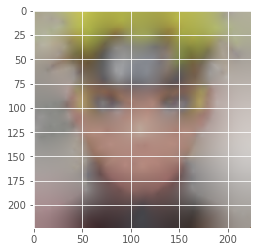

251: 0.009075, (0.163345 - 0.818016)
252: 0.009013, (0.164300 - 0.817084)
253: 0.008952, (0.165254 - 0.816151)
254: 0.008892, (0.166207 - 0.815219)
255: 0.008832, (0.167159 - 0.814292)


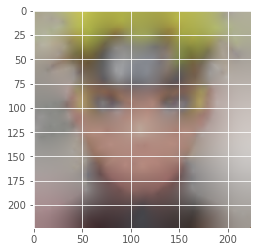

256: 0.008773, (0.168109 - 0.813372)
257: 0.008714, (0.169059 - 0.812459)
258: 0.008657, (0.170007 - 0.811553)
259: 0.008599, (0.170954 - 0.810667)
260: 0.008543, (0.171900 - 0.809789)


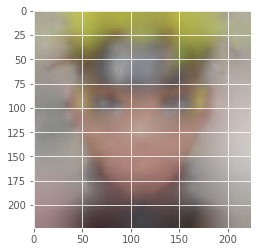

261: 0.008487, (0.172844 - 0.808914)
262: 0.008432, (0.173787 - 0.808041)
263: 0.008377, (0.174729 - 0.807171)
264: 0.008323, (0.175669 - 0.806303)
265: 0.008270, (0.176608 - 0.805438)


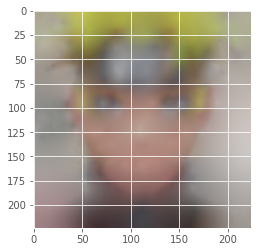

266: 0.008217, (0.177545 - 0.804576)
267: 0.008164, (0.178481 - 0.803718)
268: 0.008113, (0.179416 - 0.802863)
269: 0.008061, (0.180349 - 0.802011)
270: 0.008011, (0.181280 - 0.801163)


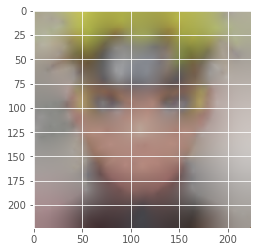

271: 0.007962, (0.182210 - 0.800320)
272: 0.007914, (0.183139 - 0.799482)
273: 0.007865, (0.184066 - 0.798647)
274: 0.007815, (0.184992 - 0.797816)
275: 0.007767, (0.185916 - 0.796989)


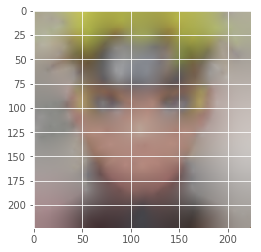

276: 0.007720, (0.186838 - 0.796185)
277: 0.007674, (0.187758 - 0.795387)
278: 0.007627, (0.188676 - 0.794591)
279: 0.007581, (0.189593 - 0.793797)
280: 0.007535, (0.190507 - 0.793003)


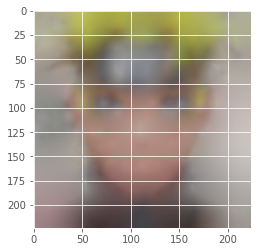

281: 0.007491, (0.190981 - 0.792212)
282: 0.007448, (0.191339 - 0.791424)
283: 0.007405, (0.191699 - 0.790639)
284: 0.007361, (0.192062 - 0.789857)
285: 0.007320, (0.192427 - 0.789092)


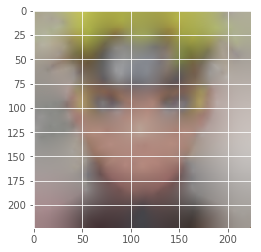

286: 0.007279, (0.192795 - 0.788335)
287: 0.007237, (0.193164 - 0.787593)
288: 0.007198, (0.193537 - 0.786860)
289: 0.007158, (0.193911 - 0.786131)
290: 0.007119, (0.194288 - 0.785422)


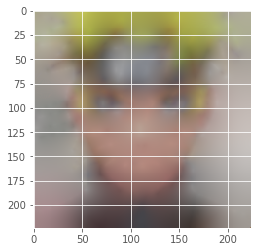

291: 0.007080, (0.194668 - 0.784715)
292: 0.007042, (0.195049 - 0.784009)
293: 0.007004, (0.195433 - 0.783305)
294: 0.006967, (0.195819 - 0.782606)
295: 0.006928, (0.196208 - 0.781927)


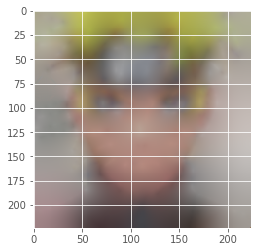

296: 0.006889, (0.196598 - 0.781250)
297: 0.006850, (0.196991 - 0.780574)
298: 0.006814, (0.197386 - 0.779901)
299: 0.006775, (0.197783 - 0.779229)


In [23]:
imgs = []
n_iterations = 300

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    sess.run(tf.global_variables_initializer())

    og_img = net_input.eval()
    
    for it_i in range(n_iterations):
        _, this_loss, synth = sess.run([optimizer, loss, net_input])
        print("%d: %f, (%f - %f)" %
            (it_i, this_loss, np.min(synth), np.max(synth)))
        if it_i % 5 == 0:
            m = vgg16.deprocess(synth[0])
            imgs.append(m)
            plt.imshow(m)
            plt.show()
    
    imgs = img_as_ubyte(imgs)
    imageio.mimsave('narutoXhinata.gif', imgs)

In [24]:
ipyd.Image(url='narutoXhinata.gif?i=0', height=300, width=300)